In [184]:
import pytesseract # type: ignore
from pytesseract import Output # type: ignore
import cv2 # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore

## OCR for word-level segmentation

In [185]:
def load_image(image_path):
    return cv2.imread(image_path)

In [182]:
def remove_shadows(image_path):
    img = cv2.imread(image_path)
    rgb_planes = cv2.split(img)

    # result_planes = []
    result_norm_planes = []
    for plane in rgb_planes:
        dilated_img = cv2.dilate(plane, np.ones((7,7), np.uint8))
        bg_img = cv2.medianBlur(dilated_img, 21)
        diff_img = 255 - cv2.absdiff(plane, bg_img)
        norm_img = cv2.normalize(diff_img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
        # result_planes.append(diff_img)
        result_norm_planes.append(norm_img)

    # result = cv2.merge(result_planes)
    result_norm = cv2.merge(result_norm_planes)
    return result_norm

In [175]:
def perform_ocr(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    custom_config = r'--oem 3 --psm 6'
    text = pytesseract.image_to_string(gray, config=custom_config)
    return text

In [191]:
def get_image_data(image):
    return pytesseract.image_to_data(image, output_type=Output.DICT)

In [176]:
def draw_bounding_boxes(image, data):
    n_boxes = len(data['level'])
    for i in range(n_boxes):
        if int(data['conf'][i]) > 10:
            (x, y, w, h) = (data['left'][i], data['top'][i], data['width'][i], data['height'][i])
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 5)
    return image

In [232]:
def save_image(image, path):
    cv2.imwrite(path, image)

In [183]:
def save_images(images, paths):
    for image, path in zip(images, paths):
        cv2.imwrite(path, image)

In [186]:
def show_image(image, title="Image"):
    # Convert the image from BGR to RGB color space
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Display the image using Matplotlib
    plt.figure(figsize=(10, 5))
    plt.imshow(image_rgb)
    plt.title(title)
    plt.axis('off')  # Hide the axis to focus on the image
    plt.show()

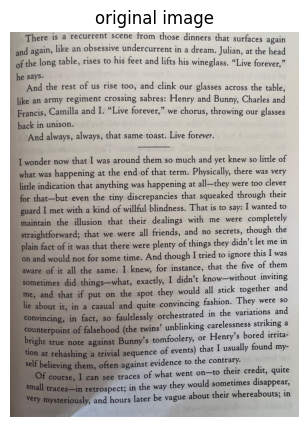

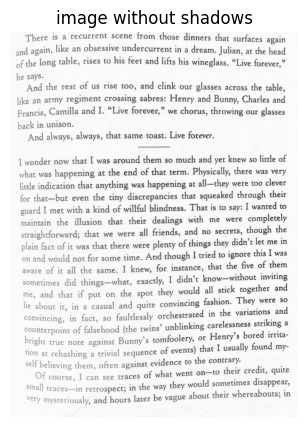

In [233]:
orig = 'images/book.png'
orig_img = load_image(orig)
show_image(orig_img, "original image")

no_shadows = remove_shadows(orig)
show_image(no_shadows, "image without shadows")
save_image(no_shadows, 'images/book_no_shadows.png')

text_orig = perform_ocr(orig_img)
text_no_shadows = perform_ocr(no_shadows)

In [234]:
print(text_orig)

There is a Pe uent scene trom those dinners that surfaces again
and again, like an obsessive undercurrent in a dream. Julian, at the head
of the long table, rises to his feet and lifts his wineglass. “Live forever,”
he says.

And the rest of us rise too, and clink our glasses across the table,
like an army regiment crossing sabres: Henry and Bunny, Charles and
Francis, Camilla and I. “Live forever,” we chorus, throwing our glasses
back in unison.

And always, always, that same toast. Live forever.

I wonder now that I was around them so much and yet knew so little of
what was happening at the end of that term. Physically, there was very
little indication that anything was happening at all—they were too clever
_ for that—but even the tiny discrepancies that squeaked through their
: guard I met with a kind of willful blindness. That is to say: I wanted to
maintain the illusion that their dealings with me were completely
a straightforward; that we were all friends, and no secrets, though 

In [235]:
print(text_no_shadows)

There is a FOercens shen trom those dinners that surfaces again
and again, like an obsessive undercurrent in a dream. Julian, at the head
of the long table, rises to his feet and lifts his wineglass. “Live forever,”
he says.

And the rest of us rise too, and clink our glasses across the table,
like an army regiment crossing sabres: Henry and Bunny, Charles and
Francis, Camilla and I. “Live forever,” we chorus, throwing our glasses
back in unison.

And always, always, that same toast. Live forever.

I wonder now that I was around them so much and yet knew so little of
what was happening at the end of that term. Physically, there was very
little indication that anything was happening at all—they were too clever
fr that—but even the tiny discrepancies that squeaked through their
guard I met with a kind of willful blindness. That is to say: I wanted to
maintain the illusion that their dealings with me were completely
straightforward; that we were all friends, and no secrets, though the
pla

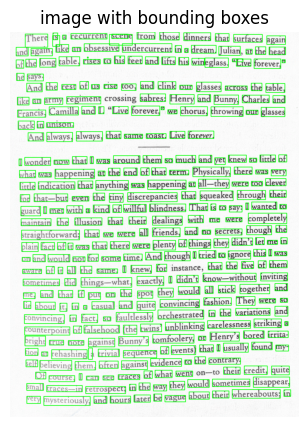

In [236]:
data = get_image_data(no_shadows)
colored_img = cv2.cvtColor(no_shadows, cv2.COLOR_BGR2RGB)
with_bb = draw_bounding_boxes(colored_img, data)
show_image(with_bb, "image with bounding boxes")

save_image(with_bb, 'images/book_ocr.png')

## OCR for context-level segmentation

In [200]:
def collect_words_and_boxes(data):
    words_and_boxes = []
    for i in range(len(data['text'])):
        if int(data['conf'][i]) > 10:
            word = data['text'][i]
            bounding_box = (data['left'][i], data['top'][i], data['width'][i], data['height'][i])
            words_and_boxes.append((word, bounding_box))
    return words_and_boxes

In [205]:
def get_surrounding_words(words, word_index, radius=10):
    start_index = max(word_index - radius, 0)
    end_index = min(word_index + radius + 1, len(words))
    return words[start_index:word_index], words[word_index + 1:end_index]

In [206]:
def find_word_context(words_and_boxes, target_word, context_radius=10):
    """Find the index of a word and its surrounding context."""
    for index, (word, _) in enumerate(words_and_boxes):
        if word.lower() == target_word.lower():
            before_words, after_words = get_surrounding_words(words_and_boxes, index, context_radius)
            return index, before_words, after_words
    return None, None, None

In [201]:
def draw_context_boxes(image, word_index, before_words, after_words, words_and_boxes):
    """Draw bounding boxes around the desired word and its context."""
    if word_index is not None:
        # desired word
        x, y, w, h = words_and_boxes[word_index][1]
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), 5)  # BGR format

        # words before the desired word
        for _, box in before_words:
            x, y, w, h = box
            cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 5)

        # words after the desired word
        for _, box in after_words:
            x, y, w, h = box
            cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 5)
    else:
        print("desired word not found in the text.")

In [240]:
img_path = 'images/book_no_shadows.png'
img = load_image(img_path)

data = get_image_data(img)
print(data)

{'level': [1, 2, 3, 4, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 3, 4, 5, 5, 3, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 4, 5, 3, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 3, 4, 5, 5, 5, 5, 5, 5, 5, 5, 2, 3, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5,

In [241]:
words_and_boxes = collect_words_and_boxes(data)
target_word = 'tomfoolery,'
word_index, before_words, after_words = find_word_context(words_and_boxes, target_word)

if word_index is not None:
    draw_context_boxes(img, word_index, before_words, after_words, words_and_boxes)
    save_image(img, 'images/book_context.png')
else:
    print("word not found.")

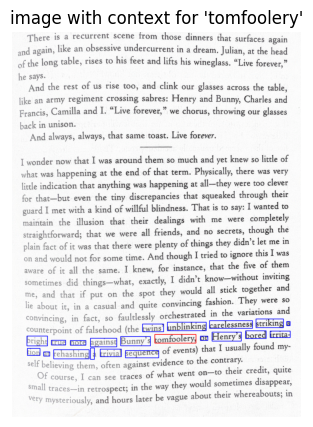

In [242]:
show_image(img, "image with context for 'tomfoolery'")

In [246]:
def create_phrase(before_words, target_word, after_words):
    # Extract just the words from before_words and after_words, ignoring bounding boxes
    before_phrase = ' '.join(word for word, _ in before_words)
    after_phrase = ' '.join(word for word, _ in after_words)

    # Combine the phrases with the target word in the middle
    full_phrase = f"{before_phrase} {target_word} {after_phrase}".strip()

    return full_phrase

In [247]:
phrase = create_phrase(before_words, target_word, after_words)
print(phrase)

twins’ unblinking carelessness striking a bright true note against Bunny’s tomfoolery, or Henry’s bored irrita- tion at rehashing a trivial sequence


## Looking up word in context

### Pull word from dictionary

In [259]:
import requests # type: ignore
import re

In [270]:
def strip_non_alphabetic_chars(word):
    # Replace non-alphabetic characters with an empty string
    return re.sub(r'[^a-zA-Z]', '', word)

In [262]:
# https://dictionaryapi.dev/

def fetch_word_details(target_word):
    # get definitions and other details for a given word from the dictionary API
    url = f"https://api.dictionaryapi.dev/api/v2/entries/en/{target_word}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        return data
    else:
        return None

In [274]:
def clean_dictionary_data(data):
    cleaned_data = []
    for entry in data:
        if 'meanings' in entry:
            for meaning in entry['meanings']:
                for definition in meaning['definitions']:
                    # build a new dictionary for each definition
                    cleaned_entry = {
                        'definition': definition['definition'],
                        'synonyms': meaning['synonyms']
                    }
                    cleaned_data.append(cleaned_entry)
    return cleaned_data

In [275]:
word_data = fetch_word_details(strip_non_alphabetic_chars(target_word))
cleaned_defs = clean_dictionary_data(word_data)
print(cleaned_defs)

[{'definition': 'Foolish behaviour or speech.', 'synonyms': ['buffoonery']}, {'definition': 'Jewellery.', 'synonyms': ['buffoonery']}]


### Choose best definition using context and light LLM

In [286]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer # type: ignore
from sentence_transformers import SentenceTransformer, util # type: ignore

In [287]:
# Load models
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')
sentence_model = SentenceTransformer('all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [307]:
def choose_best_definition(definitions, context, model, tokenizer, sentence_model):
    # use GPT-2 to help determine which definition fits best given the context
    best_fit = ""
    highest_score = float('-inf')

    for definition in definitions:
        prompt = f"In the phrase '{context}', the word is used to mean: {definition['definition']}."
        input_ids = tokenizer.encode(prompt, return_tensors='pt')
        
        # generate output and score it
        outputs = model.generate(input_ids, max_length=100, num_return_sequences=1)
        generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        
        # evaluate how well the generated text matches the context using semantic similarity
        context_embedding = sentence_model.encode(context, convert_to_tensor=True)
        response_embedding = sentence_model.encode(generated_text, convert_to_tensor=True)
        score = util.pytorch_cos_sim(context_embedding, response_embedding).item()
        
        print(f"\ndefinition: {definition['definition']}, score: {score}")
        
        if score > highest_score:
            highest_score = score
            best_fit = {'definition': definition['definition'], 'synonym(s)': definition['synonyms']}

    return best_fit

In [308]:
context = phrase
best_definition = choose_best_definition(cleaned_defs, context, model, tokenizer, sentence_model)
print("\nbest definition:", best_definition['definition'])
print("synonym(s):", ', '.join(best_definition['synonym(s)']))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



definition: Foolish behaviour or speech., score: 0.7580005526542664

definition: Jewellery., score: 0.6698314547538757

best definition: Foolish behaviour or speech.
synonym(s): buffoonery
